In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sms
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

In [2]:
df = pd.read_csv("Super_Store_data.csv", encoding = 'Latin-1') #Loading data

In [3]:
df.head(2)

Row ID        Order ID Order Date   Ship Date     Ship Mode Customer ID  \
0       1  CA-2016-152156  11/8/2016  11/11/2016  Second Class    CG-12520   
1       2  CA-2016-152156  11/8/2016  11/11/2016  Second Class    CG-12520   

  Customer Name   Segment        Country       City  ... Postal Code  Region  \
0   Claire Gute  Consumer  United States  Henderson  ...       42420   South   
1   Claire Gute  Consumer  United States  Henderson  ...       42420   South   

        Product ID   Category Sub-Category  \
0  FUR-BO-10001798  Furniture    Bookcases   
1  FUR-CH-10000454  Furniture       Chairs   

                                        Product Name   Sales  Quantity  \
0                  Bush Somerset Collection Bookcase  261.96         2   
1  Hon Deluxe Fabric Upholstered Stacking Chairs,...  731.94         3   

   Discount    Profit  
0       0.0   41.9136  
1       0.0  219.5820  

[2 rows x 21 columns]

In [4]:
df.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2121 entries, 0 to 2120
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         2121 non-null   int64  
 1   Order ID       2121 non-null   object 
 2   Order Date     2121 non-null   object 
 3   Ship Date      2121 non-null   object 
 4   Ship Mode      2121 non-null   object 
 5   Customer ID    2121 non-null   object 
 6   Customer Name  2121 non-null   object 
 7   Segment        2121 non-null   object 
 8   Country        2121 non-null   object 
 9   City           2121 non-null   object 
 10  State          2121 non-null   object 
 11  Postal Code    2121 non-null   int64  
 12  Region         2121 non-null   object 
 13  Product ID     2121 non-null   object 
 14  Category       2121 non-null   object 
 15  Sub-Category   2121 non-null   object 
 16  Product Name   2121 non-null   object 
 17  Sales          2121 non-null   float64
 18  Quantity

In [6]:
df.isna().sum()

Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64

In [7]:
df.duplicated().sum()

0

In [8]:
for i in df.columns:
    print(i,'    ', df[i].nunique())

Row ID      2121
Order ID      1764
Order Date      889
Ship Date      960
Ship Mode      4
Customer ID      707
Customer Name      707
Segment      3
Country      1
City      371
State      48
Postal Code      454
Region      4
Product ID      375
Category      1
Sub-Category      4
Product Name      380
Sales      1636
Quantity      14
Discount      11
Profit      1777


In [9]:
new_df = df[['Order Date', 'Sales']] ## making a dataframe which has sales and order date

In [10]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2121 entries, 0 to 2120
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Order Date  2121 non-null   object 
 1   Sales       2121 non-null   float64
dtypes: float64(1), object(1)
memory usage: 33.3+ KB


In [11]:
new_df['Order Date'] = pd.to_datetime(new_df['Order Date']) #Converting Order date column to Date format

C:\Users\yasar\AppData\Local\Temp\ipykernel_26324\2731095315.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Order Date'] = pd.to_datetime(new_df['Order Date']) #Converting Order date column to Date format


In [12]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2121 entries, 0 to 2120
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Order Date  2121 non-null   datetime64[ns]
 1   Sales       2121 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 33.3 KB


In [13]:
new_df.head()

Order Date      Sales
0 2016-11-08   261.9600
1 2016-11-08   731.9400
2 2015-10-11   957.5775
3 2014-06-09    48.8600
4 2014-06-09  1706.1840

In [14]:
new_df = new_df.sort_values(by = 'Order Date') # Arranging data in ascending order

In [15]:
new_df.set_index('Order Date', inplace = True) # Making Order date column as index

In [16]:
new_df.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-13', '2014-01-14', '2014-01-16',
               '2014-01-19', '2014-01-20',
               ...
               '2017-12-28', '2017-12-28', '2017-12-28', '2017-12-29',
               '2017-12-29', '2017-12-29', '2017-12-29', '2017-12-29',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=2121, freq=None)

In [17]:
new_df.head()

Sales
Order Date          
2014-01-06  2573.820
2014-01-07    76.728
2014-01-10    51.940
2014-01-11     9.940
2014-01-13   545.940

<AxesSubplot: xlabel='Order Date'>

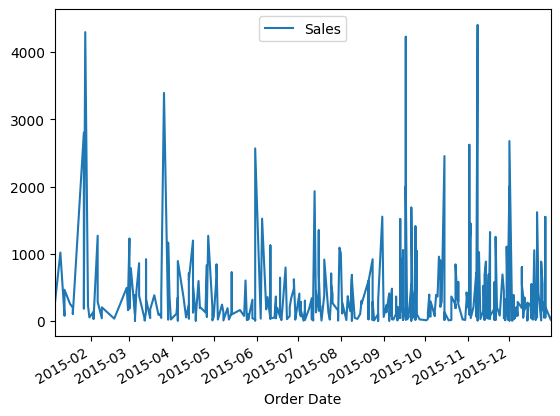

In [21]:
new_df.plot(xlim = ['2015-01-06', '2015-12-31']) # plotting the data

In [22]:
# Checking the mean is constant over time.

In [23]:
new_df['Sales'].mean()

349.8348869872702

In [24]:
new_df.loc['2014-01-01':'2014-12-31']['Sales'].mean()

373.3796985748219

In [25]:
new_df.loc['2015-01-01':'2015-12-31']['Sales'].mean()

377.2527367256637

In [26]:
new_df.loc['2016-01-01':'2016-12-31']['Sales'].mean()

353.91714590747335

In [27]:
new_df.loc['2017-01-01':'2017-12-31']['Sales'].mean()

313.97561107871724

# Time resampling

In [28]:
monthly = new_df.resample(rule = 'M').sum() # Getting sum of sales for each month (Monthly)

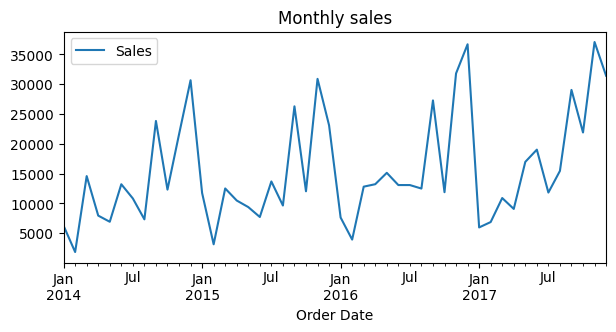

In [29]:
monthly.plot(figsize=(7, 3))  ## plotting monthly sales
plt.title('Monthly sales') 
plt.show()

In [30]:
## Checking minimum sale dates for each year

print('2014 min', monthly['2014-01-31':'2014-12-31'].idxmin())
print('2015 min', monthly['2015-01-31':'2015-12-31'].idxmin())
print('2016 min', monthly['2016-01-31':'2016-12-31'].idxmin())
print('2017 min', monthly['2017-01-31':'2017-12-31'].idxmin())

2014 min Sales   2014-02-28
dtype: datetime64[ns]
2015 min Sales   2015-02-28
dtype: datetime64[ns]
2016 min Sales   2016-02-29
dtype: datetime64[ns]
2017 min Sales   2017-01-31
dtype: datetime64[ns]


In [31]:
## Checking maximum sale dates for each year

print('2014 max', monthly['2014-01-31':'2014-12-31'].idxmax())
print('2015 max', monthly['2015-01-31':'2015-12-31'].idxmax())
print('2016 max', monthly['2016-01-31':'2016-12-31'].idxmax())
print('2017 max', monthly['2017-01-31':'2017-12-31'].idxmax())

2014 max Sales   2014-12-31
dtype: datetime64[ns]
2015 max Sales   2015-11-30
dtype: datetime64[ns]
2016 max Sales   2016-12-31
dtype: datetime64[ns]
2017 max Sales   2017-11-30
dtype: datetime64[ns]


# Checking the data is stationary or not

In [32]:
print('mean', monthly['Sales'].mean())
print('Variance', monthly['Sales'].var())

mean 15458.32906875
Variance 82879186.60643153


In [33]:
print('1st year mean', monthly.loc['2014-01-31':'2014-12-31']['Sales'].mean())
print('2nd year mean', monthly.loc['2015-01-31':'2015-12-31']['Sales'].mean())
print('3rd year mean', monthly.loc['2016-01-31':'2016-12-31']['Sales'].mean())
print('4th year mean', monthly.loc['2017-01-01':'2017-12-31']['Sales'].mean())

1st year mean 13099.404425
2nd year mean 14209.853083333333
3rd year mean 16575.11966666667
4th year mean 17948.9391


In [34]:
# mean and variance is increasing

In [35]:
print('1st year variance', monthly.loc['2014-01-31':'2014-12-31']['Sales'].var())
print('2nd year variance', monthly.loc['2015-01-31':'2015-12-31']['Sales'].var())
print('3rd year variance', monthly.loc['2016-01-31':'2016-12-31']['Sales'].var())
print('4th year variance', monthly.loc['2017-01-01':'2017-12-31']['Sales'].var())

1st year variance 70404597.92888106
2nd year variance 67216274.39158928
3rd year variance 98267711.83325763
4th year variance 102333128.8063944


In [36]:
# H0 : Data is not stationary
# H1 : Data is stationary

In [37]:
## Using Dickey Fuller Test

def adf_test(series):
    result = adfuller(series)
    print('stats:{}'.format(result[0]))
    print('p-value:{}'.format(result[1]))
    print('# Lags : {}'.format(result[2]))
    if result[1] < 0.05:
        print('Strong evidence against the H0.Reject H0.')
    else:
        print('Weak evidence against the H0, Cannot reject H0 .')

In [38]:
adf_test(monthly['Sales'])

stats:-4.699026242828902
p-value:8.450793985809671e-05
# Lags : 0
Strong evidence against the H0.Reject H0.


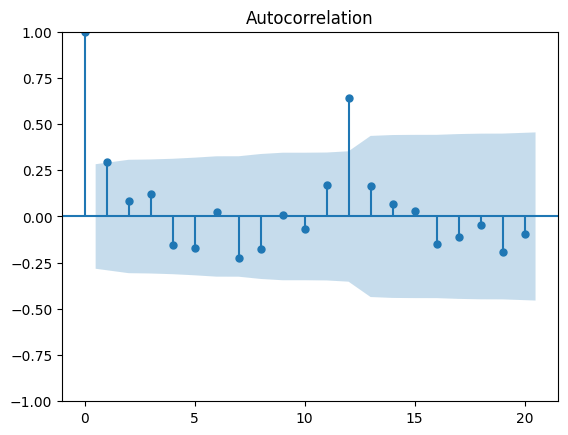

In [39]:
acf = plot_acf(monthly['Sales'], lags = 20)  # Auto correlation function

C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


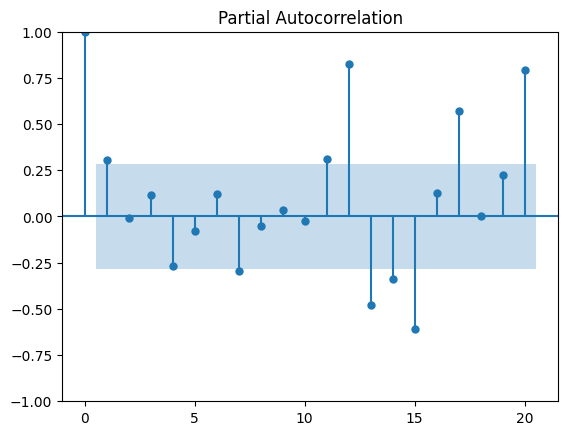

In [40]:
pacf = plot_pacf(monthly['Sales'], lags = 20)  # Partial auto correlation function

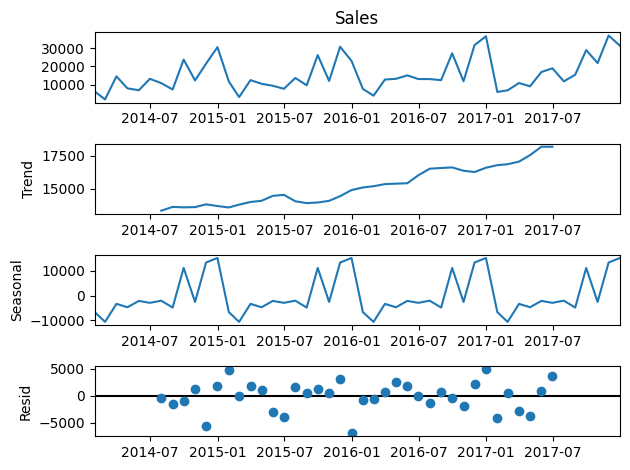

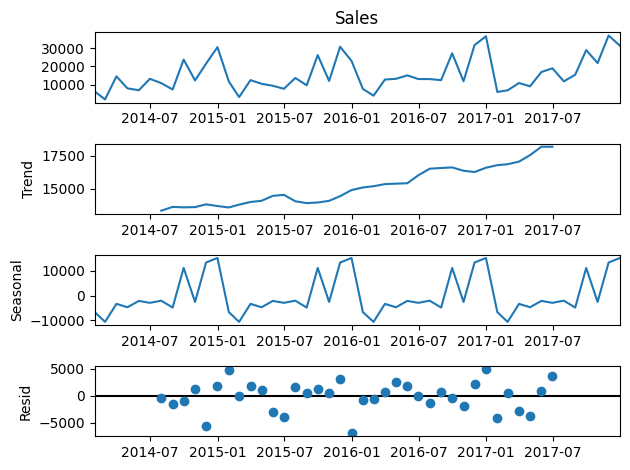

In [41]:
## Components of time sries
results = seasonal_decompose(monthly['Sales'])
results.plot()

In [42]:
# Splitting train ans test set

train_data = monthly[:'2016-12-31']
test_data = monthly['2017-01-01':]

In [43]:
## Finding best p, d, q values

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = SARIMAX(train_data['Sales'], order=param, seasonal_order=param_seasonal, enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = model.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:783.9563930702027
ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:501.9061084613861
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:455.5910508963698
ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:222.30873109763624


C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:475.6251247364523
ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:452.9534199729282
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:239.00677450384762


C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:214.9053989391663
ARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:750.7638566262547
ARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC:483.52837508576664
ARIMA(0, 0, 1)x(0, 1, 0, 12) - AIC:438.80607403658763


C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 0, 1)x(0, 1, 1, 12) - AIC:202.03739721353685
ARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:520.7392620046162
ARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC:479.5832716007877


C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 0, 1)x(1, 1, 0, 12) - AIC:237.25090765946345


C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 0, 1)x(1, 1, 1, 12) - AIC:190.67022739854377
ARIMA(0, 1, 0)x(0, 0, 0, 12) - AIC:726.0956382925132
ARIMA(0, 1, 0)x(0, 0, 1, 12) - AIC:461.429077526903
ARIMA(0, 1, 0)x(0, 1, 0, 12) - AIC:447.9118336775133
ARIMA(0, 1, 0)x(0, 1, 1, 12) - AIC:200.23687023288372
ARIMA(0, 1, 0)x(1, 0, 0, 12) - AIC:467.4530330233081
ARIMA(0, 1, 0)x(1, 0, 1, 12) - AIC:458.17927727011653


C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 1, 0)x(1, 1, 0, 12) - AIC:214.92337424622372
ARIMA(0, 1, 0)x(1, 1, 1, 12) - AIC:197.992566265728


C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 1, 1)x(0, 0, 0, 12) - AIC:696.4301151517225
ARIMA(0, 1, 1)x(0, 0, 1, 12) - AIC:439.15013992585637
ARIMA(0, 1, 1)x(0, 1, 0, 12) - AIC:422.551624229648
ARIMA(0, 1, 1)x(0, 1, 1, 12) - AIC:181.62658417937274
ARIMA(0, 1, 1)x(1, 0, 0, 12) - AIC:476.3592523560157


C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 1, 1)x(1, 0, 1, 12) - AIC:435.12031818791115
ARIMA(0, 1, 1)x(1, 1, 0, 12) - AIC:219.42390134926717


C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 1, 1)x(1, 1, 1, 12) - AIC:177.09019855369712
ARIMA(1, 0, 0)x(0, 0, 0, 12) - AIC:747.1223441295974
ARIMA(1, 0, 0)x(0, 0, 1, 12) - AIC:483.96300031572184
ARIMA(1, 0, 0)x(0, 1, 0, 12) - AIC:457.5732680045706


C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 0, 0)x(0, 1, 1, 12) - AIC:218.9473121333741
ARIMA(1, 0, 0)x(1, 0, 0, 12) - AIC:475.91687959704825
ARIMA(1, 0, 0)x(1, 0, 1, 12) - AIC:477.10382002782643
ARIMA(1, 0, 0)x(1, 1, 0, 12) - AIC:218.16697116647103


C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 0, 0)x(1, 1, 1, 12) - AIC:218.02741135435915
ARIMA(1, 0, 1)x(0, 0, 0, 12) - AIC:716.8782231114649
ARIMA(1, 0, 1)x(0, 0, 1, 12) - AIC:460.3318249283723
ARIMA(1, 0, 1)x(0, 1, 0, 12) - AIC:439.5998808291647


C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 0, 1)x(0, 1, 1, 12) - AIC:200.51109072645133


C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 0, 1)x(1, 0, 0, 12) - AIC:457.65608891533407
ARIMA(1, 0, 1)x(1, 0, 1, 12) - AIC:454.7811769727538
ARIMA(1, 0, 1)x(1, 1, 0, 12) - AIC:218.77038063620398


C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 0, 1)x(1, 1, 1, 12) - AIC:200.5403192187731
ARIMA(1, 1, 0)x(0, 0, 0, 12) - AIC:720.4849371818987
ARIMA(1, 1, 0)x(0, 0, 1, 12) - AIC:459.6391434259076
ARIMA(1, 1, 0)x(0, 1, 0, 12) - AIC:445.63911763741515
ARIMA(1, 1, 0)x(0, 1, 1, 12) - AIC:201.3486706994808
ARIMA(1, 1, 0)x(1, 0, 0, 12) - AIC:455.03176157074057


C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 1, 0)x(1, 0, 1, 12) - AIC:456.1582822162167
ARIMA(1, 1, 0)x(1, 1, 0, 12) - AIC:197.99051098853414


C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 1, 0)x(1, 1, 1, 12) - AIC:199.98936580158517
ARIMA(1, 1, 1)x(0, 0, 0, 12) - AIC:698.0075287120734
ARIMA(1, 1, 1)x(0, 0, 1, 12) - AIC:441.0967213561423
ARIMA(1, 1, 1)x(0, 1, 0, 12) - AIC:424.3161253829856


C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 1, 1)x(0, 1, 1, 12) - AIC:183.48725739230514
ARIMA(1, 1, 1)x(1, 0, 0, 12) - AIC:446.40681655295924
ARIMA(1, 1, 1)x(1, 0, 1, 12) - AIC:437.03236946871164


C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 1, 1)x(1, 1, 0, 12) - AIC:201.74921638066473
ARIMA(1, 1, 1)x(1, 1, 1, 12) - AIC:183.64262834223015


C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [44]:
# Training the SARIMAX model.

model = SARIMAX(train_data['Sales'], order=(0, 1, 1), seasonal_order=(1, 1, 1, 12), enforce_stationarity=False,
                                            enforce_invertibility=False)
results = model.fit()
print(results.summary().tables[1])

C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7309      0.172     -4.255      0.000      -1.068      -0.394
ar.S.L12      -0.8556      0.222     -3.847      0.000      -1.292      -0.420
ma.S.L12       0.3275      0.325      1.006      0.314      -0.310       0.965
sigma2      8.051e+06   8.56e-10    9.4e+15      0.000    8.05e+06    8.05e+06


<AxesSubplot: ylabel='Density'>

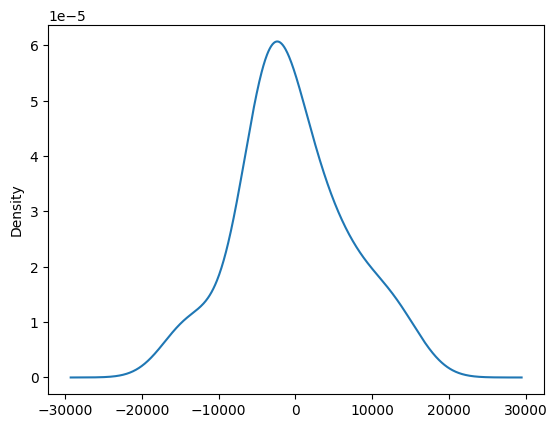

In [45]:
results.resid.plot(kind = 'kde') ## Residuals are in normal distribution

In [46]:
## Getting predictions

pred = results.get_prediction(start=test_data.index[0], end = test_data.index[-1], dynamic=False)
pred_ci = pred.conf_int()
print(pred_ci)

             lower Sales   upper Sales
2017-01-31   7227.734203  18392.695791
2017-02-28     42.331632  11606.859845
2017-03-31   7678.925213  19625.659021
2017-04-30   7770.176092  20087.275091
2017-05-31   7943.711593  20620.272131
2017-06-30   4203.081999  17229.003282
2017-07-31   8794.179733  22160.029779
2017-08-31   6352.777335  20049.655632
2017-09-30  21101.649816  35121.037402
2017-10-31   6322.048107  20655.629387
2017-11-30  26663.779516  41303.210742
2017-12-31  21184.878440  36121.461263


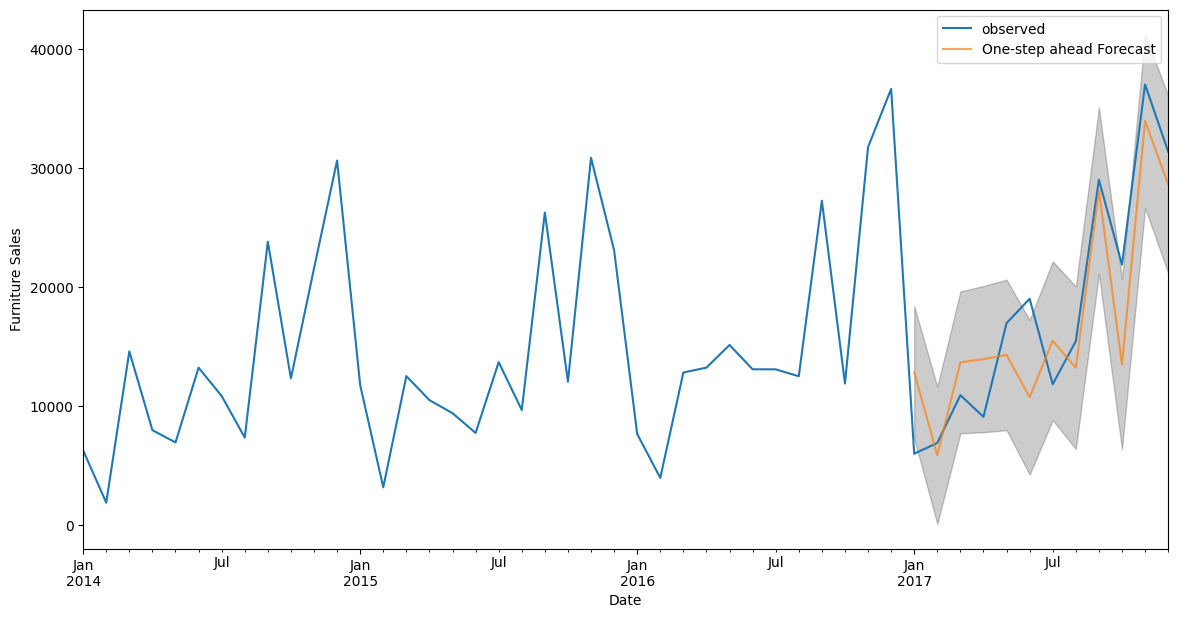

In [47]:
## Plotting the predictions of test set and train data

ax = monthly['Sales'].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [48]:
# Checking Root mean squared error of the model

print('RMSE', rmse(pred.predicted_mean, test_data['Sales']))
print('MEAN', test_data['Sales'].mean())

RMSE 4672.0403334500625
MEAN 17948.9391


# Forecasting 2018 sales using monthly model

In [49]:
next_year_pred = results.get_prediction(start=pd.to_datetime('2017-12-01'), end=pd.to_datetime('2018-12-01') , dynamic=False)
next_year_pred_ci = next_year_pred.conf_int()

In [50]:
next_year_pred.predicted_mean

2017-12-31    28653.169851
2018-01-31    11127.418658
2018-02-28     6955.448207
2018-03-31    15679.702891
2018-04-30    16071.272656
2018-05-31    17754.584228
2018-06-30    15486.344229
2018-07-31    16171.983015
2018-08-31    15342.609664
2018-09-30    30141.096568
2018-10-31    14861.646401
2018-11-30    34856.958201
2018-12-31    38275.714035
Freq: M, Name: predicted_mean, dtype: float64

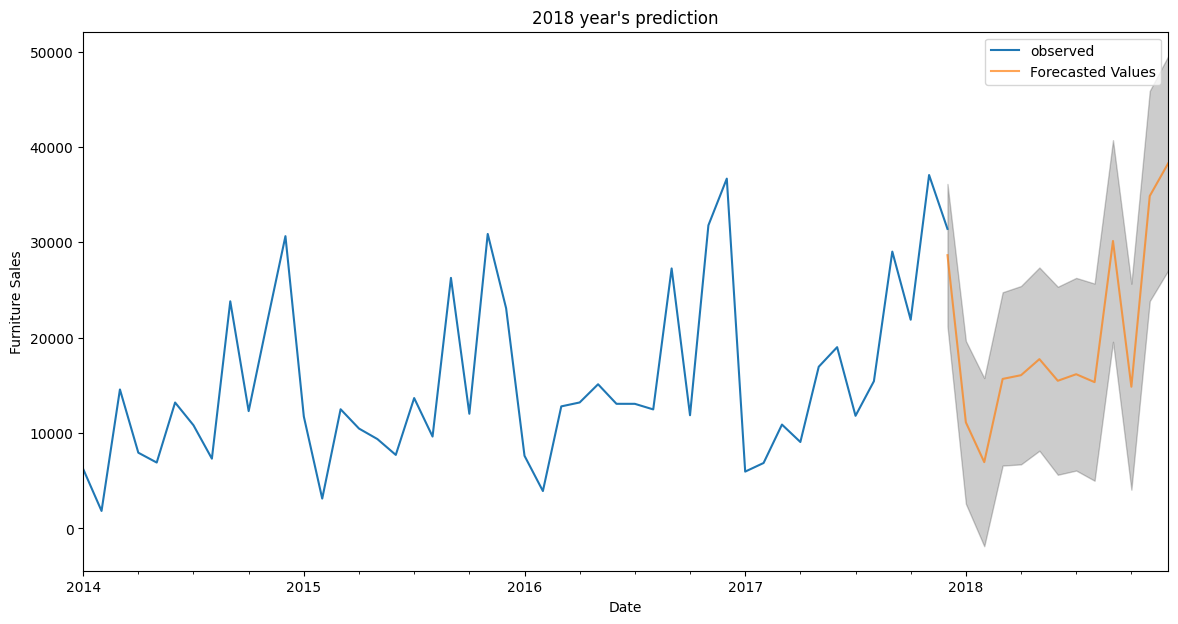

In [51]:
# Plotting 2018 predictions

ax = monthly['Sales'].plot(label='observed')
next_year_pred.predicted_mean.plot(ax=ax, label='Forecasted Values', alpha=.7, figsize=(14, 7))
ax.fill_between(next_year_pred_ci.index, next_year_pred_ci.iloc[:, 0],
                next_year_pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.title("2018 year's prediction")
plt.show()

In [685]:
next_year_predictions = next_year_pred.predicted_mean
next_year_predictions

2018-01-31    11127.418658
2018-02-28     6955.448207
2018-03-31    15679.702891
2018-04-30    16071.272656
2018-05-31    17754.584228
2018-06-30    15486.344229
2018-07-31    16171.983015
2018-08-31    15342.609664
2018-09-30    30141.096568
2018-10-31    14861.646401
2018-11-30    34856.958201
2018-12-31    38275.714035
Freq: M, Name: predicted_mean, dtype: float64

# Quarterly

In [65]:
quarterly = new_df.resample(rule = 'QS').sum()

<AxesSubplot: xlabel='Order Date'>

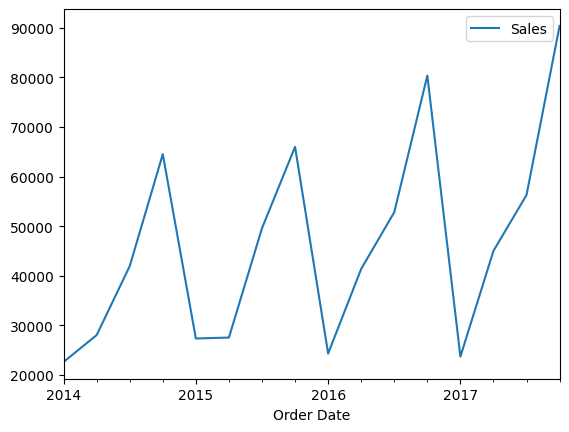

In [66]:
quarterly.plot()

In [67]:
# It seems there is seasonality in quarters.

In [68]:
print('mean', quarterly['Sales'].mean())
print('Variance', quarterly['Sales'].var())

mean 46374.98720625001
Variance 440519971.7628075


In [69]:
print('1st year mean', quarterly.loc['2014-01-31':'2014-12-31']['Sales'].mean())
print('2nd year mean', quarterly.loc['2015-01-31':'2015-12-31']['Sales'].mean())
print('3rd year mean', quarterly.loc['2016-01-31':'2016-12-31']['Sales'].mean())
print('4th year mean', quarterly.loc['2017-01-01':'2017-12-31']['Sales'].mean())

1st year mean 44845.57136666666
2nd year mean 47714.7128
3rd year mean 58184.01666666666
4th year mean 53846.817299999995


In [70]:
print('1st year variance', quarterly.loc['2014-01-31':'2014-12-31']['Sales'].var())
print('2nd year variance', quarterly.loc['2015-01-31':'2015-12-31']['Sales'].var())
print('3rd year variance', quarterly.loc['2016-01-31':'2016-12-31']['Sales'].var())
print('4th year variance', quarterly.loc['2017-01-01':'2017-12-31']['Sales'].var())

1st year variance 338429063.41708094
2nd year variance 371812774.19435334
3rd year variance 400556122.89886236
4th year variance 774461525.4151058


In [71]:
## Components of the time series

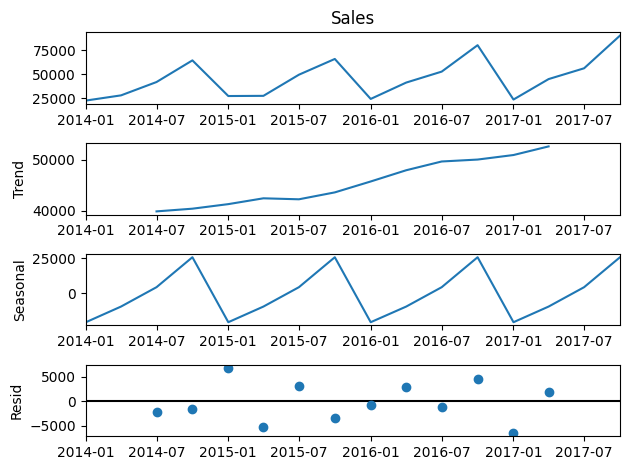

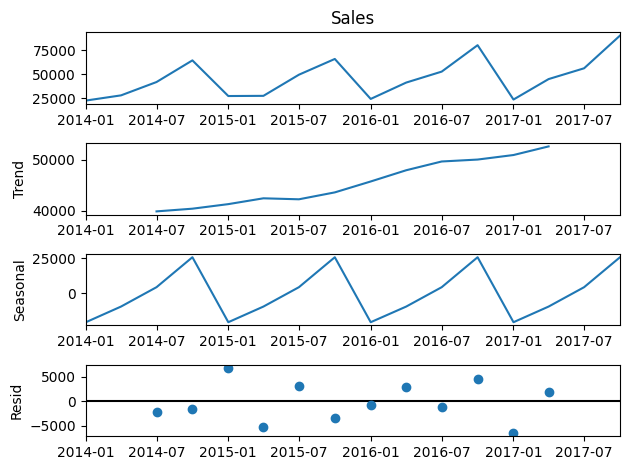

In [72]:
sea1 = seasonal_decompose(quarterly['Sales'])
sea1.plot()

In [73]:
quart_train_data = quarterly[:'2016-04-01']
quart_test_data = quarterly['2016-07-01':]

In [74]:
quart_test_data

Sales
Order Date            
2016-07-01  52814.6322
2016-10-01  80334.9208
2017-01-01  23723.8142
2017-04-01  45032.1030
2017-07-01  56283.1020
2017-10-01  90348.2500

In [75]:
p_qu = d_qu = q_qu = range(0, 2)
pdq_qu = list(itertools.product(p_qu, d_qu, q_qu))
seasonal_pdq_qu = [(x[0], x[1], x[2], 4) for x in pdq_qu]

print('{} X {}'.format(pdq_qu[1], seasonal_pdq_qu[1]))

(0, 0, 1) X (0, 0, 1, 4)


In [76]:
for param in pdq_qu:
    for param_seasonal in seasonal_pdq_qu:
        try:
            quart_model = SARIMAX(quart_train_data['Sales'], order=param, seasonal_order=param_seasonal, enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = quart_model.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 4) - AIC:219.97938336996586
ARIMA(0, 0, 0)x(0, 0, 1, 4) - AIC:117.25068541046761
ARIMA(0, 0, 0)x(0, 1, 0, 4) - AIC:105.07062327653955
ARIMA(0, 0, 0)x(0, 1, 1, 4) - AIC:25.907852773905216
ARIMA(0, 0, 0)x(1, 0, 0, 4) - AIC:125.22219923375116
ARIMA(0, 0, 0)x(1, 0, 1, 4) - AIC:106.96953565661998
ARIMA(0, 0, 0)x(1, 1, 0, 4) - AIC:46.31427064195685


C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observation

ARIMA(0, 0, 0)x(1, 1, 1, 4) - AIC:24.944790814284342
ARIMA(0, 0, 1)x(0, 0, 0, 4) - AIC:194.20633358075645
ARIMA(0, 0, 1)x(0, 0, 1, 4) - AIC:99.51979649505735
ARIMA(0, 0, 1)x(0, 1, 0, 4) - AIC:87.5328138000912
ARIMA(0, 0, 1)x(0, 1, 1, 4) - AIC:6.0
ARIMA(0, 0, 1)x(1, 0, 0, 4) - AIC:144.99256251910307
ARIMA(0, 0, 1)x(1, 0, 1, 4) - AIC:100.68575030336767


C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('

ARIMA(0, 0, 1)x(1, 1, 0, 4) - AIC:45.66453962907073
ARIMA(0, 0, 1)x(1, 1, 1, 4) - AIC:8.0
ARIMA(0, 1, 0)x(0, 0, 0, 4) - AIC:186.70580394179984
ARIMA(0, 1, 0)x(0, 0, 1, 4) - AIC:92.62668220374901
ARIMA(0, 1, 0)x(0, 1, 0, 4) - AIC:87.13230074401805
ARIMA(0, 1, 0)x(0, 1, 1, 4) - AIC:4.0
ARIMA(0, 1, 0)x(1, 0, 0, 4) - AIC:109.53028979269197
ARIMA(0, 1, 0)x(1, 0, 1, 4) - AIC:94.09990483829881


C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('

ARIMA(0, 1, 0)x(1, 1, 0, 4) - AIC:-2.8669167373052558
ARIMA(0, 1, 0)x(1, 1, 1, 4) - AIC:6.0
ARIMA(0, 1, 1)x(0, 0, 0, 4) - AIC:165.35569488849134
ARIMA(0, 1, 1)x(0, 0, 1, 4) - AIC:70.0766012833636
ARIMA(0, 1, 1)x(0, 1, 0, 4) - AIC:68.23011221403156
ARIMA(0, 1, 1)x(0, 1, 1, 4) - AIC:6.0
ARIMA(0, 1, 1)x(1, 0, 0, 4) - AIC:111.82946894684267


C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('

ARIMA(0, 1, 1)x(1, 0, 1, 4) - AIC:71.67802998310817
ARIMA(0, 1, 1)x(1, 1, 0, 4) - AIC:26.35950131668459
ARIMA(0, 1, 1)x(1, 1, 1, 4) - AIC:8.0
ARIMA(1, 0, 0)x(0, 0, 0, 4) - AIC:210.1629722313704


C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters e

ARIMA(1, 0, 0)x(0, 0, 1, 4) - AIC:109.9951867591642
ARIMA(1, 0, 0)x(0, 1, 0, 4) - AIC:106.68092923412922
ARIMA(1, 0, 0)x(0, 1, 1, 4) - AIC:25.53089615138659
ARIMA(1, 0, 0)x(1, 0, 0, 4) - AIC:115.76555573186363


C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 0, 0)x(1, 0, 1, 4) - AIC:117.74443126451665
ARIMA(1, 0, 0)x(1, 1, 0, 4) - AIC:25.536189307052023
ARIMA(1, 0, 0)x(1, 1, 1, 4) - AIC:27.536184690211613
ARIMA(1, 0, 1)x(0, 0, 0, 4) - AIC:185.91374019554723
ARIMA(1, 0, 1)x(0, 0, 1, 4) - AIC:95.263749187692


C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('

ARIMA(1, 0, 1)x(0, 1, 0, 4) - AIC:87.44852541685
ARIMA(1, 0, 1)x(0, 1, 1, 4) - AIC:8.0
ARIMA(1, 0, 1)x(1, 0, 0, 4) - AIC:116.76203214660337
ARIMA(1, 0, 1)x(1, 0, 1, 4) - AIC:97.14208851094155
ARIMA(1, 0, 1)x(1, 1, 0, 4) - AIC:27.551371218204853
ARIMA(1, 0, 1)x(1, 1, 1, 4) - AIC:10.0
ARIMA(1, 1, 0)x(0, 0, 0, 4) - AIC:187.6727357857914


C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('

ARIMA(1, 1, 0)x(0, 0, 1, 4) - AIC:92.07716879747785
ARIMA(1, 1, 0)x(0, 1, 0, 4) - AIC:87.57677784665127
ARIMA(1, 1, 0)x(0, 1, 1, 4) - AIC:6.0
ARIMA(1, 1, 0)x(1, 0, 0, 4) - AIC:94.32817995191851
ARIMA(1, 1, 0)x(1, 0, 1, 4) - AIC:96.31963859401438
ARIMA(1, 1, 0)x(1, 1, 0, 4) - AIC:6.0
ARIMA(1, 1, 0)x(1, 1, 1, 4) - AIC:8.0
ARIMA(1, 1, 1)x(0, 0, 0, 4) - AIC:167.68265897930806


C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\base\mo

ARIMA(1, 1, 1)x(0, 0, 1, 4) - AIC:70.81894382476173
ARIMA(1, 1, 1)x(0, 1, 0, 4) - AIC:6.0
ARIMA(1, 1, 1)x(0, 1, 1, 4) - AIC:8.0
ARIMA(1, 1, 1)x(1, 0, 0, 4) - AIC:91.7309389076579
ARIMA(1, 1, 1)x(1, 0, 1, 4) - AIC:72.31878042791189
ARIMA(1, 1, 1)x(1, 1, 0, 4) - AIC:8.0
ARIMA(1, 1, 1)x(1, 1, 1, 4) - AIC:10.0


C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [77]:
# Training the SARIMAX model.
quart_model = SARIMAX(quart_train_data['Sales'], order=(0, 1, 1), seasonal_order=(0, 1, 1, 4), enforce_stationarity=False,
                                            enforce_invertibility=False)
quart_results = quart_model.fit()
print(quart_results.summary().tables[1])

C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -4.6309         -0        inf      0.000      -4.631      -4.631
ma.S.L4             0         -0        nan        nan           0           0
sigma2      1.164e+08         -0       -inf      0.000    1.16e+08    1.16e+08


C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tools\eval_measures.py:406: RuntimeWarning: invalid value encountered in log
  return -2.0 * llf + np.log(nobs) * df_modelwc
C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tools\eval_measures.py:431: RuntimeWarning: invalid value encountered in log
  return -2.0 * llf + 2 * np.log(np.log(nobs)) * df_modelwc
C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:2979: RuntimeWarning: divide by zero encountered in divide
  return self.params / self.bse
C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:2979: RuntimeWarning: invalid value encountered in divide
  return self.params / self.bse
C:\Users\yasar\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:467: RuntimeWarning: Mean of empty slice.
  xo = x - x.mean()
C:\Users\yasar\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.t

<AxesSubplot: ylabel='Density'>

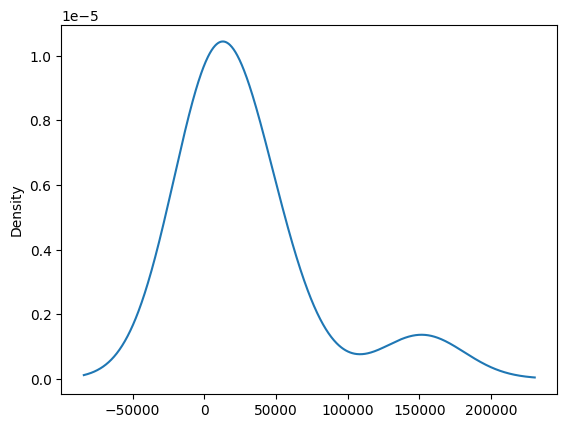

In [78]:
quart_results.resid.plot(kind = 'kde')

In [79]:
pred_quart = quart_results.get_prediction(start=quart_test_data.index[0], end = quart_test_data.index[-1], dynamic=False)
pred_ci_quart = pred_quart.conf_int()
print(pred_ci_quart)

              lower Sales    upper Sales
2016-07-01  -37903.100674  157970.185300
2016-10-01  -48010.065440  200891.630066
2017-01-01 -111437.305942  181031.092168
2017-04-01 -113319.207426  217019.215651
2017-07-01 -169955.301294  310917.400146
2017-10-01 -198410.411264  372186.990115


In [80]:
quart_test_data['Sales'], pred_quart.predicted_mean

(Order Date
 2016-07-01    52814.6322
 2016-10-01    80334.9208
 2017-01-01    23723.8142
 2017-04-01    45032.1030
 2017-07-01    56283.1020
 2017-10-01    90348.2500
 Freq: QS-JAN, Name: Sales, dtype: float64,
 2016-07-01    60033.542313
 2016-10-01    76440.782313
 2017-01-01    34796.893113
 2017-04-01    51850.004113
 2017-07-01    70481.049426
 2017-10-01    86888.289426
 Freq: QS-JAN, Name: predicted_mean, dtype: float64)

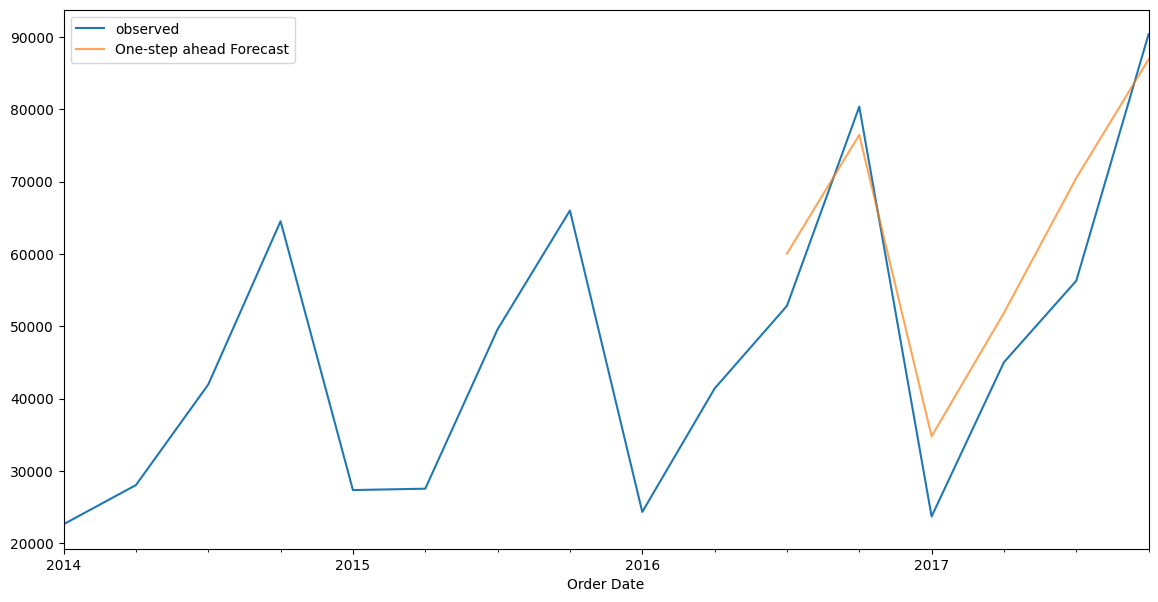

In [81]:
q_ax = quarterly['Sales'].plot(label='observed')
pred_quart.predicted_mean.plot(ax=q_ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci_quart.index, pred_ci_quart.iloc[:, 0],
                pred_ci_quart.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [82]:
print('RMSE', rmse(pred_quart.predicted_mean, quart_test_data['Sales']))
print('MEAN', quart_test_data['Sales'].mean())

RMSE 8659.550298707098
MEAN 58089.47036666667


In [83]:
rmse(pred_quart.predicted_mean, quart_test_data['Sales'])/quart_test_data['Sales'].mean()

0.1490726330270724

# Forecasting 2018 sales using quarterly model

In [84]:
next_year_pred_q = quart_results.get_prediction(start=pd.to_datetime('2018-01-01'), end = pd.to_datetime('2018-12-01'), dynamic=False)

In [85]:
next_year_pred_ci_q = next_year_pred_q.conf_int()
print(next_year_pred_ci_q)

              lower Sales    upper Sales
2018-01-01 -278763.405980  369252.206432
2018-04-01 -296264.573148  420859.595599
2018-07-01 -357050.413115  518907.526192
2018-10-01 -397531.281636  592202.874713
2019-01-01 -490166.382204  601550.196882


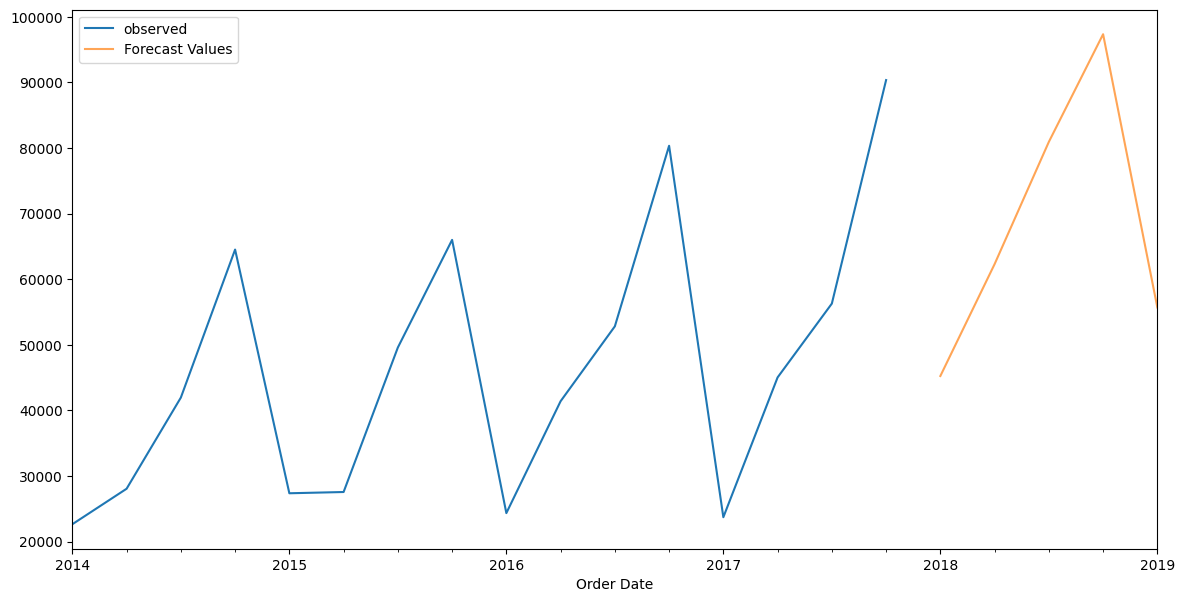

In [363]:
q_ax = quarterly['Sales'].plot(label='observed')
next_year_pred_q.predicted_mean.plot(ax=q_ax, label='Forecast Values', alpha=.7, figsize=(14, 7))

ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [87]:
next_year_predictions_quart = next_year_pred_q.predicted_mean

In [88]:
next_year_predictions_quart

2018-01-01    45244.400226
2018-04-01    62297.511226
2018-07-01    80928.556539
2018-10-01    97335.796539
2019-01-01    55691.907339
Freq: QS-JAN, Name: predicted_mean, dtype: float64

By the two models monthly and quarterly quarterly model has less rmse.

# LSTM

In [52]:
monthly.head()

Sales
Order Date           
2014-01-31   6242.525
2014-02-28   1839.658
2014-03-31  14573.956
2014-04-30   7944.837
2014-05-31   6912.787

In [53]:
train_monthly = monthly[:'2016-12-31']
test_monthly = monthly['2017-01-31':]

In [54]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()  

In [55]:
scaler.fit(train_monthly)

MinMaxScaler()

In [56]:
scaled_train = scaler.transform(train_monthly) # Scaling the train data
scaled_test = scaler.transform(test_monthly)   # Scaling the test data

In [57]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [58]:
n_input = 12     # Using past 12 months data to predict present month
n_features = 1   # predicting one feature

In [60]:
# Generating training samples with 12 months past data as independent features and present value is dependent feature
generator = TimeseriesGenerator(scaled_train, scaled_train, length = n_input, batch_size = 1)

 If we have sales like 1, 2, 3, 4, 5, 6, 7

 n_input = 3, n_features = 1

 generatr generates data in the format like 1 2 3 -> 4, 2 3 4 ->5, 3 4 5->6, and so on

In [126]:
X, y = generator[0]

In [127]:
X.flatten(), y

(array([0.12637733, 0.        , 0.36551787, 0.1752395 , 0.14561614,
        0.32625647, 0.25779667, 0.15731449, 0.63080992, 0.30036947,
        0.56618107, 0.8268395 ]),
 array([[0.28417197]]))

In [128]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [129]:
## Building LSTM network

model = Sequential()
model.add(LSTM(100, activation = 'relu', input_shape = (n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               40800     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [130]:
model.fit(generator, epochs = 50) # fitting training samples

Epoch 1/50
24/24 [==============================] - 2s 5ms/step - loss: 0.1008
Epoch 2/50
24/24 [==============================] - 0s 5ms/step - loss: 0.0721
Epoch 3/50
24/24 [==============================] - 0s 5ms/step - loss: 0.0736
Epoch 4/50
24/24 [==============================] - 0s 5ms/step - loss: 0.0657
Epoch 5/50
24/24 [==============================] - 0s 5ms/step - loss: 0.0622
Epoch 6/50
24/24 [==============================] - 0s 5ms/step - loss: 0.0621
Epoch 7/50
24/24 [==============================] - 0s 5ms/step - loss: 0.0627
Epoch 8/50
24/24 [==============================] - 0s 5ms/step - loss: 0.0642
Epoch 9/50
24/24 [==============================] - 0s 5ms/step - loss: 0.0659
Epoch 10/50
24/24 [==============================] - 0s 5ms/step - loss: 0.0584
Epoch 11/50
24/24 [==============================] - 0s 5ms/step - loss: 0.0554
Epoch 12/50
24/24 [==============================] - 0s 5ms/step - loss: 0.0655
Epoch 13/50
24/24 [==============================

In [131]:
loss_per_epoch = model.history.history['loss']

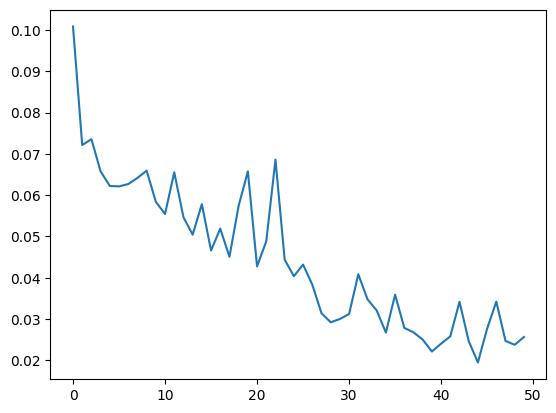

In [132]:
plt.plot(loss_per_epoch) ## Plotting the loss of the model

In [133]:
last_train_batch = scaled_train[-12:]
last_train_batch = last_train_batch.reshape(1, n_input, n_features)

In [134]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 241ms/step


array([[0.26080078]], dtype=float32)

In [135]:
test_predictions = []
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

In [136]:
# Getting predictions for the test set
for i in range(len(test_monthly)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis = 1)

1/1 [==============================] - 0s 33ms/step


In [137]:
test_predictions

[array([0.26080078], dtype=float32),
 array([0.25379944], dtype=float32),
 array([0.28468633], dtype=float32),
 array([0.29528707], dtype=float32),
 array([0.3300359], dtype=float32),
 array([0.31748995], dtype=float32),
 array([0.33746228], dtype=float32),
 array([0.419097], dtype=float32),
 array([0.6801671], dtype=float32),
 array([0.5487956], dtype=float32),
 array([1.1209705], dtype=float32),
 array([0.99008965], dtype=float32)]

In [138]:
true_predictions = scaler.inverse_transform(test_predictions) # Predictions will be in scaled form converting
                                                              #  those scaled values to normal values

In [139]:
test_monthly['predictions'] = true_predictions

C:\Users\yasar\AppData\Local\Temp\ipykernel_26324\1822793774.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<AxesSubplot: xlabel='Order Date'>

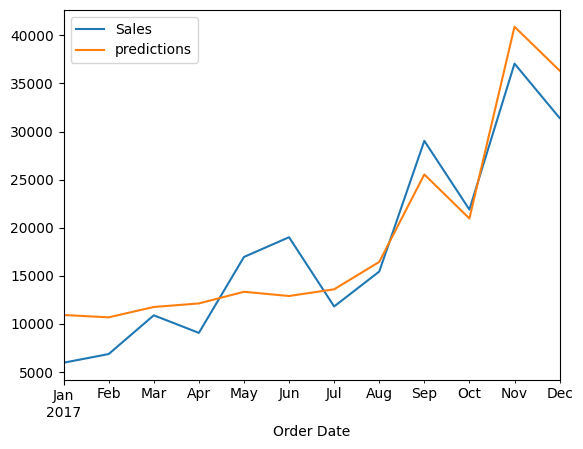

In [140]:
test_monthly.plot()  ## Plotting the predcitions vs real test data

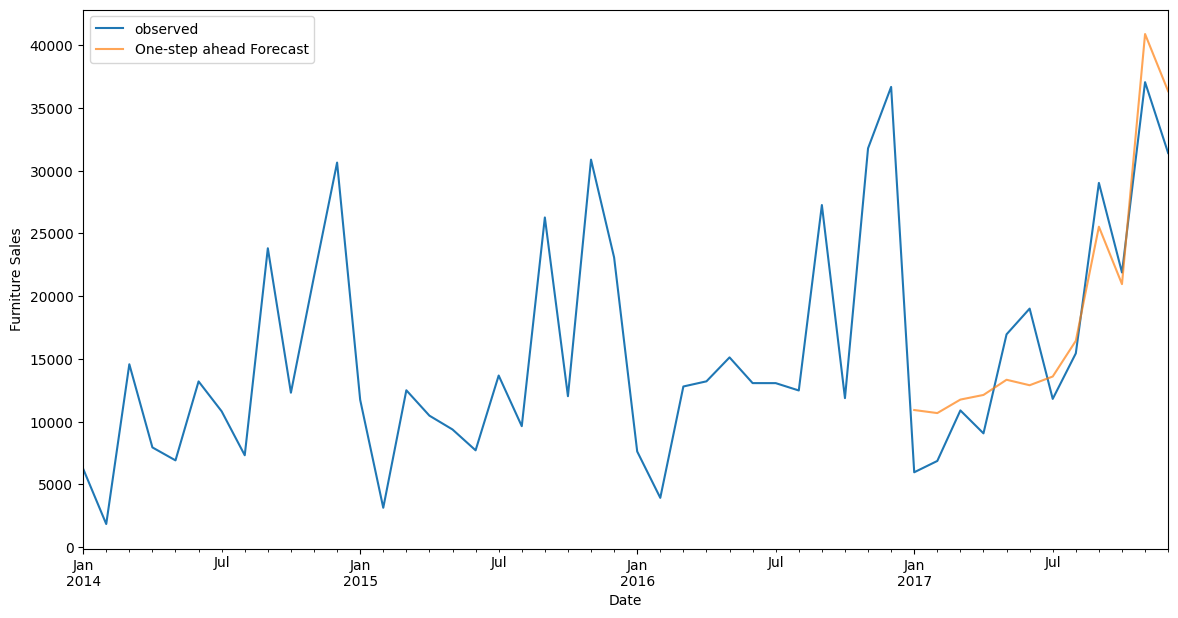

In [141]:
ax = monthly['Sales'].plot(label='observed')
test_monthly['predictions'].plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [142]:
print(rmse(test_monthly['predictions'], test_monthly['Sales']))
print(test_monthly['Sales'].mean())

3604.581607430193
17948.9391


In [143]:
rmse(test_monthly['predictions'], test_monthly['Sales'])/test_monthly['Sales'].mean()

0.20082421514429188

# Forecasting 2018 sales using LSTM

In [120]:
new_predictions = []
prev_test_batch = scaled_test[-n_input:]
current_test_batch = prev_test_batch.reshape((1, n_input, n_features))

In [121]:
# Getting predictions for year 2018

for i in range(12):
    new_pred = model.predict(current_test_batch)[0]
    new_predictions.append(new_pred)
    current_test_batch = np.append(current_test_batch[:, 1:, :], [[new_pred]], axis = 1)

1/1 [==============================] - 0s 28ms/step


In [122]:
new_year_predictions = scaler.inverse_transform(new_predictions)

In [123]:
## making a dataframe for 2018 predictions

date = ['2018-01-31', '2018-02-28', '2018-03-31', '2018-04-30', '2018-05-31', '2018-06-30', '2018-07-31', 
        '2018-08-31', '2018-09-30', '2018-10-31', '2018-11-30', '2018-12-31']
year_2018 = pd.DataFrame()
year_2018['Date'] = date
year_2018['Date'] = pd.to_datetime(year_2018['Date'])
year_2018['new_year_sales'] = new_year_predictions
year_2018.set_index('Date', inplace = True)

In [144]:
test_data

ds           y
36 2017-01-31   5964.0320
37 2017-02-28   6866.3374
38 2017-03-31  10893.4448
39 2017-04-30   9065.9581
40 2017-05-31  16957.5582
41 2017-06-30  19008.5867
42 2017-07-31  11813.0220
43 2017-08-31  15441.8740
44 2017-09-30  29028.2060
45 2017-10-31  21884.0682
46 2017-11-30  37056.7150
47 2017-12-31  31407.4668

In [124]:
year_2018

new_year_sales
Date                      
2018-01-31    12922.972471
2018-02-28    13142.273796
2018-03-31    13952.172287
2018-04-30    14329.525479
2018-05-31    20523.223498
2018-06-30    23015.478744
2018-07-31    16917.586380
2018-08-31    22908.782520
2018-09-30    32158.635532
2018-10-31    33464.044026
2018-11-30    42063.488439
2018-12-31    34457.776034

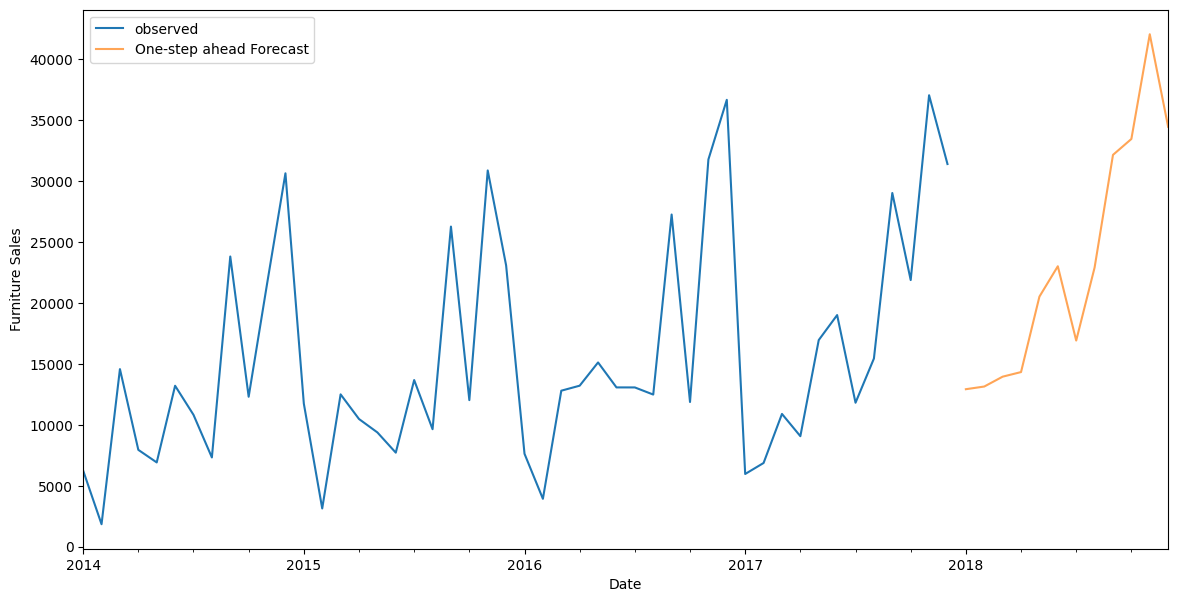

In [125]:
#Plotting forecasted values with past data

ax = monthly['Sales'].plot(label='observed')
year_2018['new_year_sales'].plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

# FBProhet library

In [87]:
from prophet.plot import plot_plotly, plot_components_plotly
from prophet import Prophet

In [88]:
monthly_fb = monthly.reset_index()

In [89]:
monthly_fb.columns = ['ds', 'y']  # Renaming the column names that could be accepted by fbprophet

In [90]:
monthly_fb.shape

(48, 2)

In [91]:
sales = monthly_fb['y']
sales

0      6242.5250
1      1839.6580
2     14573.9560
3      7944.8370
4      6912.7870
5     13206.1256
6     10821.0510
7      7320.3465
8     23816.4808
9     12304.2470
10    21564.8727
11    30645.9665
12    11739.9416
13     3134.3740
14    12499.7830
15    10475.6985
16     9374.9505
17     7714.1790
18    13674.4200
19     9638.5922
20    26273.0230
21    12026.6235
22    30880.8325
23    23085.8192
24     7622.7430
25     3925.5510
26    12801.0920
27    13212.0900
28    15119.8350
29    13070.5720
30    13068.5190
31    12483.2323
32    27262.8809
33    11872.5770
34    31783.6288
35    36678.7150
36     5964.0320
37     6866.3374
38    10893.4448
39     9065.9581
40    16957.5582
41    19008.5867
42    11813.0220
43    15441.8740
44    29028.2060
45    21884.0682
46    37056.7150
47    31407.4668
Name: y, dtype: float64

In [92]:
train_data = monthly_fb[:36]
test_data = monthly_fb[36:]

In [93]:
test_data

ds           y
36 2017-01-31   5964.0320
37 2017-02-28   6866.3374
38 2017-03-31  10893.4448
39 2017-04-30   9065.9581
40 2017-05-31  16957.5582
41 2017-06-30  19008.5867
42 2017-07-31  11813.0220
43 2017-08-31  15441.8740
44 2017-09-30  29028.2060
45 2017-10-31  21884.0682
46 2017-11-30  37056.7150
47 2017-12-31  31407.4668

In [97]:
m = Prophet()

In [98]:
m.fit(train_data)  # Traing the model

21:22:20 - cmdstanpy - INFO - Chain [1] start processing
21:22:20 - cmdstanpy - INFO - Chain [1] done processing


In [99]:
future = m.make_future_dataframe(periods = 24, freq = 'M')  #Predicting future 24 months sales

In [100]:
forecast = m.predict(future)

In [101]:
forecast.tail

<bound method NDFrame.tail of            ds         trend    yhat_lower    yhat_upper   trend_lower  \
0  2014-01-31  11855.404298   3959.063619   8936.700960  11855.404298   
1  2014-02-28  11979.916723   -644.518001   3974.674496  11979.916723   
2  2014-03-31  12117.769765   9708.602802  14376.108735  12117.769765   
3  2014-04-30  12251.175934   6616.939501  11263.917640  12251.175934   
4  2014-05-31  12389.028976   6007.847637  10774.317989  12389.028976   
5  2014-06-30  12522.435145   6952.068508  11736.858988  12522.435145   
6  2014-07-31  12660.288185   8984.944406  13663.619254  12660.288185   
7  2014-08-31  12798.141227   5594.265939  10422.195570  12798.141227   
8  2014-09-30  12931.547396  21989.854831  26679.593831  12931.547396   
9  2014-10-31  13069.400438   8556.944493  13295.768103  13069.400438   
10 2014-11-30  13202.806608  24255.635628  28997.713909  13202.806608   
11 2014-12-31  13340.659651  25146.664005  29902.423950  13340.659651   
12 2015-01-31  13478.

In [102]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

ds          yhat    yhat_lower    yhat_upper
0  2014-01-31   6351.609724   3959.063619   8936.700960
1  2014-02-28   1640.594591   -644.518001   3974.674496
2  2014-03-31  12075.533484   9708.602802  14376.108735
3  2014-04-30   8897.275189   6616.939501  11263.917640
4  2014-05-31   8415.972410   6007.847637  10774.317989
5  2014-06-30   9460.266402   6952.068508  11736.858988
6  2014-07-31  11157.856796   8984.944406  13663.619254
7  2014-08-31   8076.689841   5594.265939  10422.195570
8  2014-09-30  24296.591131  21989.854831  26679.593831
9  2014-10-31  10826.901850   8556.944493  13295.768103
10 2014-11-30  26553.923960  24255.635628  28997.713909
11 2014-12-31  27495.307732  25146.664005  29902.423950
12 2015-01-31   8512.538898   6059.878995  10978.819583
13 2015-02-28   4205.213947   1983.137661   6528.904761
14 2015-03-31  14848.111155  12668.639483  17325.018714
15 2015-04-30  10317.204740   8138.534789  12617.742913
16 2015-05-31   8712.075026   6346.709385  11132.106222
17 2015-06-30  10438.241721   8106.105221  12705.992164
18 2015-07-31  13621.828783  11130.210059  16139.864567
19 2015-08-31   9396.795270   7039.249901  11625.314905
20 2015-09-30  26360.864033  23996.670449  28881.538057
21 2015-10-31  13573.355410  11355.328027  15775.078788
22 2015-11-30  28303.491259  25832.391859  30706.435529
23 2015-12-31  26068.443268  23565.281268  28559.214828
24 2016-01-31  10734.410623   8419.705879  13098.901559
25 2016-02-29   3060.709395    532.064606   5538.689385
26 2016-03-31  12955.488409  10714.516878  15469.089238
27 2016-04-30  12422.080079  10082.627563  14853.966068
28 2016-05-31  14280.061180  11991.523512  16546.990731
29 2016-06-30  14095.106099  11703.692165  16507.317381
30 2016-07-31  12782.192347  10360.671225  15235.616187
31 2016-08-31  11963.910987   9712.110879  14298.701624
32 2016-09-30  26691.821155  24399.928188  28926.155592
33 2016-10-31  11797.764093   9523.358177  14151.555663
34 2016-11-30  29367.490499  27054.270206  31783.237114
35 2016-12-31  36845.867220  34635.438597  39105.507228
36 2017-01-31  10749.613741   8323.846124  13037.104266
37 2017-02-28   5591.388871   3015.206741   7864.453634
38 2017-03-31  15777.026118  13385.804784  18216.153638
39 2017-04-30  13932.036043  11678.093792  16402.374537
40 2017-05-31  14605.694714  12214.937370  16893.511371
41 2017-06-30  15012.751202  12722.257745  17369.276705
42 2017-07-31  15211.043390  13062.784825  17640.544435
43 2017-08-31  13265.710452  10830.502805  15674.858179
44 2017-09-30  28740.043765  26491.757218  31158.771195
45 2017-10-31  14568.033399  11979.563447  16897.657037
46 2017-11-30  31242.307582  28821.623378  33783.323051
47 2017-12-31  35422.677577  33124.458310  37681.760655
48 2018-01-31  12851.530028  10350.246092  15285.621360
49 2018-02-28   8140.623280   5695.508365  10351.912246
50 2018-03-31  18575.682170  16307.288817  20880.036289
51 2018-04-30  15397.540002  12936.398903  17655.980807
52 2018-05-31  14916.357220  12327.973365  17161.749040
53 2018-06-30  15960.767339  13763.278313  18447.693353
54 2018-07-31  17658.477730  15434.779655  20077.236902
55 2018-08-31  14577.430773  12095.786217  16970.303975
56 2018-09-30  30797.448190  28445.061949  33283.122664
57 2018-10-31  17327.878906  15018.521358  19811.895578
58 2018-11-30  33055.017141  30682.524396  35217.796881
59 2018-12-31  33996.520909  31767.661980  36284.301627

# 2018 sales prediction using FBProphet

In [103]:
plot_plotly(m, forecast)

In [104]:
plot_components_plotly(m, forecast)

C:\Users\yasar\anaconda3\Lib\site-packages\plotly\io\_json.py:534: UserWarning:

Discarding nonzero nanoseconds in conversion.



In [105]:
forecast['yhat']

0      6351.609724
1      1640.594591
2     12075.533484
3      8897.275189
4      8415.972410
5      9460.266402
6     11157.856796
7      8076.689841
8     24296.591131
9     10826.901850
10    26553.923960
11    27495.307732
12     8512.538898
13     4205.213947
14    14848.111155
15    10317.204740
16     8712.075026
17    10438.241721
18    13621.828783
19     9396.795270
20    26360.864033
21    13573.355410
22    28303.491259
23    26068.443268
24    10734.410623
25     3060.709395
26    12955.488409
27    12422.080079
28    14280.061180
29    14095.106099
30    12782.192347
31    11963.910987
32    26691.821155
33    11797.764093
34    29367.490499
35    36845.867220
36    10749.613741
37     5591.388871
38    15777.026118
39    13932.036043
40    14605.694714
41    15012.751202
42    15211.043390
43    13265.710452
44    28740.043765
45    14568.033399
46    31242.307582
47    35422.677577
48    12851.530028
49     8140.623280
50    18575.682170
51    15397.540002
52    14916.

In [106]:
predictions = forecast['yhat']

In [107]:
predictions

0      6351.609724
1      1640.594591
2     12075.533484
3      8897.275189
4      8415.972410
5      9460.266402
6     11157.856796
7      8076.689841
8     24296.591131
9     10826.901850
10    26553.923960
11    27495.307732
12     8512.538898
13     4205.213947
14    14848.111155
15    10317.204740
16     8712.075026
17    10438.241721
18    13621.828783
19     9396.795270
20    26360.864033
21    13573.355410
22    28303.491259
23    26068.443268
24    10734.410623
25     3060.709395
26    12955.488409
27    12422.080079
28    14280.061180
29    14095.106099
30    12782.192347
31    11963.910987
32    26691.821155
33    11797.764093
34    29367.490499
35    36845.867220
36    10749.613741
37     5591.388871
38    15777.026118
39    13932.036043
40    14605.694714
41    15012.751202
42    15211.043390
43    13265.710452
44    28740.043765
45    14568.033399
46    31242.307582
47    35422.677577
48    12851.530028
49     8140.623280
50    18575.682170
51    15397.540002
52    14916.

In [108]:
test_data['y']

36     5964.0320
37     6866.3374
38    10893.4448
39     9065.9581
40    16957.5582
41    19008.5867
42    11813.0220
43    15441.8740
44    29028.2060
45    21884.0682
46    37056.7150
47    31407.4668
Name: y, dtype: float64

In [109]:
monthly_fb['y'], predictions

(0      6242.5250
 1      1839.6580
 2     14573.9560
 3      7944.8370
 4      6912.7870
 5     13206.1256
 6     10821.0510
 7      7320.3465
 8     23816.4808
 9     12304.2470
 10    21564.8727
 11    30645.9665
 12    11739.9416
 13     3134.3740
 14    12499.7830
 15    10475.6985
 16     9374.9505
 17     7714.1790
 18    13674.4200
 19     9638.5922
 20    26273.0230
 21    12026.6235
 22    30880.8325
 23    23085.8192
 24     7622.7430
 25     3925.5510
 26    12801.0920
 27    13212.0900
 28    15119.8350
 29    13070.5720
 30    13068.5190
 31    12483.2323
 32    27262.8809
 33    11872.5770
 34    31783.6288
 35    36678.7150
 36     5964.0320
 37     6866.3374
 38    10893.4448
 39     9065.9581
 40    16957.5582
 41    19008.5867
 42    11813.0220
 43    15441.8740
 44    29028.2060
 45    21884.0682
 46    37056.7150
 47    31407.4668
 Name: y, dtype: float64,
 0      6351.609724
 1      1640.594591
 2     12075.533484
 3      8897.275189
 4      8415.972410
 5      94

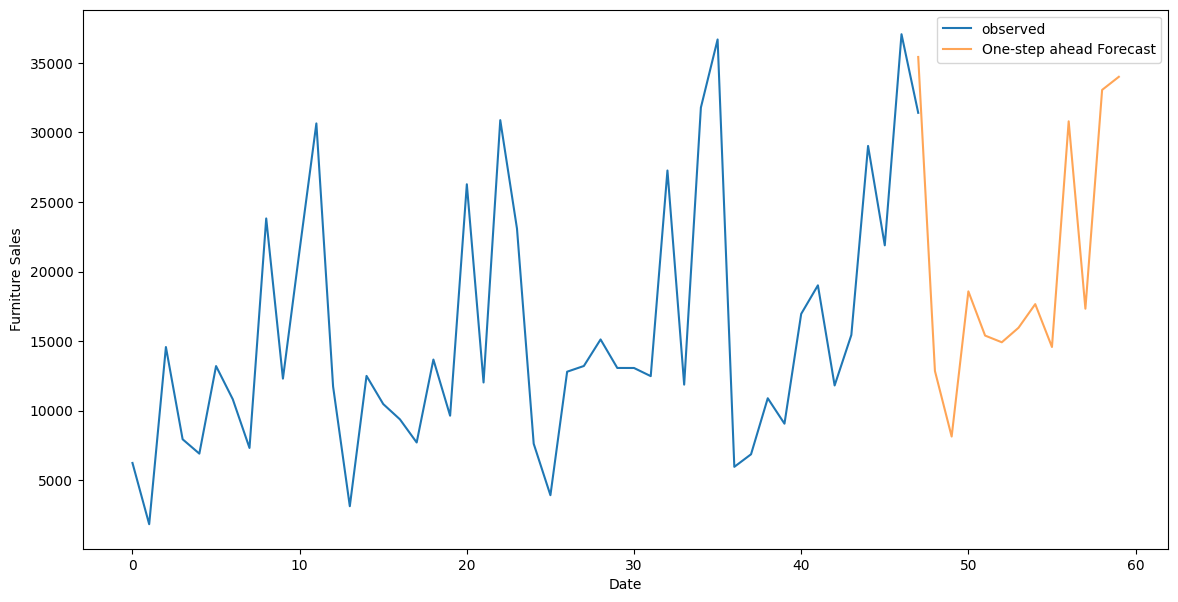

In [112]:
ax = monthly_fb['y'].plot(label='observed')
predictions[47:].plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')

plt.legend()
plt.show()

In [114]:
train_data.shape, monthly_fb['y'].shape

((36, 2), (48,))

In [117]:
print(rmse(predictions[36:48], monthly_fb['y'][36:48]))
print(monthly_fb['y'][36:48].mean())

4216.7544946574735
17948.9391


In [118]:
4216.7544946574735/17948.9391

0.23493057005566828